Building an AI-powered Wealth Advisor Copilot — a platform that helps financial advisors.

Dependencies and API Keys

In [5]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")


In [6]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIM-Certification-Challenge - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

API DATA

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

tavily_tool = TavilySearchResults(max_results=5)
arxiv_tool = ArxivQueryRun()
yfinance_tool = YahooFinanceNewsTool()

USER_AGENT environment variable not set, consider setting it to identify your requests.
/tmp/ipykernel_37051/1722258708.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


AI Agent

In [8]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "datanote/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

Chuncking Documents

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 100,
)
split_documents = text_splitter.split_documents(docs)
len(split_documents)


576

Embedding Model

In [10]:
from langchain_openai.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Qdrant Vectore Database

In [11]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="client_collection",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)


vector_store = QdrantVectorStore(
    client=client,
    collection_name="client_collection",
    embedding=embeddings,
)

Add splitted Documents to vectore store

In [12]:
_ = vector_store.add_documents(documents=split_documents)

Retriever

In [18]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

Contextual Compression Retriever

Prompt Template

In [21]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

Open AI Chat GPT Model

In [22]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

Langgraph State

In [23]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

In [24]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever

def retrieve(state: State) -> State:
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

In [25]:
def generate(state):
    docs_content = "\n\n".join([doc.page_content for doc in state["context"]])
    messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
    response = llm.invoke(messages)
    return {"response": response.content}

Building Langgraph

In [26]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

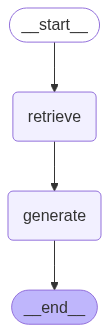

In [27]:
rag_graph

In [ ]:
response = rag_graph.invoke({"question": "what is financial Analysis?"})

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Bad request: invalid \'dotted_order\': dotted_order ec50f01a-166c-4282-8391-f7b43bc75e5f has timestamp 2025-08-04 03:48:02.218044 +0000 UTC earlier than parent timestamp 2025-08-04 03:48:03.715417 +0000 UTC for run_id:ec50f01a-166c-4282-8391-f7b43bc75e5f trace_id:f223d267-5284-414a-b54e-5b316da0404e dotted_order:20250804T034802227406Zf223d267-5284-414a-b54e-5b316da0404e.20250804T034803694427Zc5bede32-29c3-4b73-949b-a2d4be17e2e8.20250804T034803715417Z8ae69eb2-26bf-497e-bfcd-121a5dc09140.20250804T034802218044Zec50f01a-166c-4282-8391-f7b43bc75e5f parent_run_id:8ae69eb2-26bf-497e-bfcd-121a5dc09140"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs

In [29]:
response["response"]

"Financial analysis involves evaluating the performance of a full portfolio or its individual components. It typically includes two main aspects: measuring returns (either pre-tax or after-tax) and assessing those returns to understand the investment's effectiveness. The analysis may also involve benchmarking and comparing performance across different investment strategies or portfolios to determine relative success."

Tool Belt

In [30]:

from langchain_core.tools import tool

@tool
def ai_rag_tool(question: str) -> str:
    """
    Use this tool to get information from the knowledge base.
    """
    response = rag_graph.invoke({"question": question})
    return {
        "messages": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }



In [31]:
tool_belt = [
    tavily_tool,
    arxiv_tool,
    yfinance_tool,
    ai_rag_tool
]

In [53]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)


In [54]:
model = model.bind_tools(tool_belt)

Langgraph Agent

In [55]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.documents import Document


class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  context: list[Document]

In [56]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {
    "messages" : [response],
    "context": state.get("context", [])
  }

tool_node = ToolNode(tool_belt)

In [57]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [58]:
uncompiled_graph.set_entry_point("agent")

In [59]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)


In [60]:
uncompiled_graph.add_edge("action", "agent")

In [61]:
complied_graph = uncompiled_graph.compile()

In [62]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="What is financial Analysis?")]}

async for chunk in complied_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")


Receiving update from node: 'agent'
[AIMessage(content="Financial analysis is the process of evaluating a company's financial data to understand its financial health, performance, and stability. It involves examining financial statements such as the balance sheet, income statement, and cash flow statement to assess profitability, liquidity, solvency, and operational efficiency. Financial analysis helps stakeholders, including management, investors, creditors, and analysts, make informed decisions regarding investments, lending, and strategic planning. Techniques used in financial analysis include ratio analysis, trend analysis, and comparative analysis.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 242, 'total_tokens': 339, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_toke

In [63]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, then search each of the authors to find out their latest Tweet using Tavily!")]}

async for chunk in complied_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YNQdefjaZWGhOPJCKz3RmC4P', 'function': {'arguments': '{"query": "QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_puEINcVFi0aoItZJco2Wzja5', 'function': {'arguments': '{"query": "latest Tweet of the author of QLoRA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 263, 'total_tokens': 321, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-C0gp1XlSWc8zNmjz4oIp8Um58UbsQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9a40cf7d-8a75-44f4-8e63-e08893a2adb9-0', tool_calls=[{'name'

Abstracted SDG

In [64]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [65]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs[:20], testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/17 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/20 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/25 [00:00<?, ?it/s]

Property 'summary' already exists in node '18a75a'. Skipping!
Property 'summary' already exists in node '26c5da'. Skipping!
Property 'summary' already exists in node 'e67877'. Skipping!
Property 'summary' already exists in node '50c98d'. Skipping!
Property 'summary' already exists in node 'a8a751'. Skipping!
Property 'summary' already exists in node 'b40730'. Skipping!
Property 'summary' already exists in node '227f36'. Skipping!
Property 'summary' already exists in node '2a7cab'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/21 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/61 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'b40730'. Skipping!
Property 'summary_embedding' already exists in node 'e67877'. Skipping!
Property 'summary_embedding' already exists in node 'a8a751'. Skipping!
Property 'summary_embedding' already exists in node '18a75a'. Skipping!
Property 'summary_embedding' already exists in node '26c5da'. Skipping!
Property 'summary_embedding' already exists in node '50c98d'. Skipping!
Property 'summary_embedding' already exists in node '227f36'. Skipping!
Property 'summary_embedding' already exists in node '2a7cab'. Skipping!


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [66]:
dataset

Testset(samples=[TestsetSample(eval_sample=SingleTurnSample(user_input='Who is Scanlan in the context of private wealth management?', retrieved_contexts=None, reference_contexts=['Strategic Asset Allocation and Investment Policy Investment policy in private wealth management differs from institutional asset allocation in a number of ways. For example, any Markowitz mean–variance optimization must reflect after-tax values for both risk and return. The portfolio may include low-basis stock. The diversification and return attributes of alternative investments must be balanced with their tax inefficiency. Individuals may have stock options. A broad interpretation of asset allocation must include off-balance-sheet assets and liabilities, such as defined-benefit pensions and prospective college tuition payments. Finally, in an after-tax environment, the hurdles for market timing and tactical asset allocation, which were already high, are worse. The preceding paragraph conveys something of th

In [93]:
for test_row in dataset:
  inputs = {"messages" : [HumanMessage(content=test_row.eval_sample.user_input)]}
  response = complied_graph.invoke(inputs)
  test_row.eval_sample.response = response["messages"][-1].content
  test_row.eval_sample.retrieved_contexts = test_row.eval_sample.reference_contexts

In [94]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Who is Scanlan in the context of private wealt...,[Strategic Asset Allocation and Investment Pol...,[Strategic Asset Allocation and Investment Pol...,"In the context of private wealth management, t...","Scanlan is one of the authors, along with Bron...",single_hop_specifc_query_synthesizer
1,who is bodie in private wealth management?,[Policy Investment policy in private wealth ma...,[Policy Investment policy in private wealth ma...,Bodie in private wealth management emphasizes ...,Bodie is referenced in the context of retirees...,single_hop_specifc_query_synthesizer
2,What mean Inheritance in portfolio management?,[Implementation Other Issues • Asset mix • Sty...,[Implementation Other Issues • Asset mix • Sty...,Inheritance in portfolio management refers to ...,Inheritance is one of the implementation issue...,single_hop_specifc_query_synthesizer
3,what CFA Institute say about hedge funds for p...,[Private Wealth Management 6 ©2010 The Researc...,[Private Wealth Management 6 ©2010 The Researc...,The CFA Institute states that hedge funds are ...,Runquist (2004) introduces a set of articles f...,single_hop_specifc_query_synthesizer
4,How can private wealth managers utilize after-...,[<1-hop>\n\nPrivate Wealth Management 6 ©2010 ...,[<1-hop>\n\nPrivate Wealth Management 6 ©2010 ...,Private wealth managers can enhance portfolio ...,Private wealth managers can enhance portfolio ...,multi_hop_abstract_query_synthesizer
5,How do private wealth managers incorporate tax...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,Private wealth managers incorporate tax consid...,Private wealth managers incorporate tax consid...,multi_hop_abstract_query_synthesizer
6,how private wealth managers use the concept of...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,Private wealth managers incorporate the concep...,Private wealth managers incorporate longevity ...,multi_hop_abstract_query_synthesizer
7,How does tax-adjusted asset allocation influen...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,Tax-adjusted asset allocation plays a crucial ...,Tax-adjusted asset allocation affects asset lo...,multi_hop_abstract_query_synthesizer
8,how private wealth manager do rebalancing diff...,[<1-hop>\n\nPortfolio Implementation After the...,[<1-hop>\n\nPortfolio Implementation After the...,Private wealth managers differ from institutio...,Private wealth management differs from institu...,multi_hop_specific_query_synthesizer
9,How do Ibbotson's guidelines on savings rates ...,[<1-hop>\n\nSavings and Wealth Accumulation. I...,[<1-hop>\n\nSavings and Wealth Accumulation. I...,Ibbotson's guidelines on savings rates for inc...,"Ibbotson, Xiong, Kreitler, Kreitler, and Chen ...",multi_hop_specific_query_synthesizer


In [95]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [96]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))

In [97]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[5]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-KU4B0uriZ43b7j5r6Fxzq9KV on tokens per min (TPM): Limit 30000, Used 28513, Requested 2065. Please try again in 1.156s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[11]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-KU4B0uriZ43b7j5r6Fxzq9KV on tokens per min (TPM): Limit 30000, Used 29459, Requested 2134. Please try again in 3.186s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[19]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-KU4B0uriZ43b7j5r6Fxzq9KV on tokens per min (TPM): Limit 30000, Used 29731, Reques

{'context_recall': 0.9479, 'faithfulness': 0.3912, 'factual_correctness': 0.2850, 'answer_relevancy': 0.8706, 'context_entity_recall': 0.5350, 'noise_sensitivity_relevant': 0.0809}

In [99]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Please enter your Cohere API key!")

In [100]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

In [101]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

def retrieve_adjusted(state):
  compressor = CohereRerank(model="rerank-v3.5", top_n=10)
  compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever, search_kwargs={"k": 5}
  )
  retrieved_docs = compression_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

In [102]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

Generation

In [103]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

In [104]:
def generate(state):
    docs_content = "\n\n".join([doc.page_content for doc in state["context"]])
    messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
    response = llm.invoke(messages)
    return {"response": response.content}

Building RAG Graph with Lang Graph

In [106]:
graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve_adjusted, generate])
graph_builder.add_edge(START, "retrieve_adjusted")
rag_graph = graph_builder.compile()

In [109]:
response = rag_graph.invoke({"question": "what is financial Analysis?"})

In [110]:
response["response"]

'Based on the provided context, financial analysis involves the performance evaluation of a full portfolio or its components, typically focusing on two main aspects: measuring returns (either pre-tax or after-tax) and assessing those returns. It may include benchmarking approaches and methods to address challenges such as unrealized capital gains. Financial analysis is used within areas like private equity and private wealth management to track trends and assess investment performance.'

In [112]:
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool

@tool
def ai_rag_tool(question: str) -> str:
    """
    Use this tool to get information from the knowledge base.
    """
    response = rag_graph.invoke({"question": question})
    return {
        "messages": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }

In [113]:
tool_belt = [
    tavily_tool,
    arxiv_tool,
    yfinance_tool,
    ai_rag_tool
]

In [114]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

In [115]:
model = model.bind_tools(tool_belt)

In [117]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.documents import Document


class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  context: list[Document]

In [118]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {
    "messages" : [response],
    "context": state.get("context", [])
  }

tool_node = ToolNode(tool_belt)

In [119]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [120]:
uncompiled_graph.set_entry_point("agent")

In [121]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

In [122]:
uncompiled_graph.add_edge("action", "agent")

In [123]:
complied_graph = uncompiled_graph.compile()

In [124]:
for test_row in dataset:
  inputs = {"messages" : [HumanMessage(content=test_row.eval_sample.user_input)]}
  response = complied_graph.invoke(inputs)
  test_row.eval_sample.response = response["messages"][-1].content
  test_row.eval_sample.retrieved_contexts = test_row.eval_sample.reference_contexts

In [125]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Who is Scanlan in the context of private wealt...,[Strategic Asset Allocation and Investment Pol...,[Strategic Asset Allocation and Investment Pol...,"In the context of private wealth management, ""...","Scanlan is one of the authors, along with Bron...",single_hop_specifc_query_synthesizer
1,who is bodie in private wealth management?,[Policy Investment policy in private wealth ma...,[Policy Investment policy in private wealth ma...,Bodie in private wealth management refers to Z...,Bodie is referenced in the context of retirees...,single_hop_specifc_query_synthesizer
2,What mean Inheritance in portfolio management?,[Implementation Other Issues • Asset mix • Sty...,[Implementation Other Issues • Asset mix • Sty...,Inheritance in portfolio management refers to ...,Inheritance is one of the implementation issue...,single_hop_specifc_query_synthesizer
3,what CFA Institute say about hedge funds for p...,[Private Wealth Management 6 ©2010 The Researc...,[Private Wealth Management 6 ©2010 The Researc...,The CFA Institute views hedge funds not as a s...,Runquist (2004) introduces a set of articles f...,single_hop_specifc_query_synthesizer
4,How can private wealth managers utilize after-...,[<1-hop>\n\nPrivate Wealth Management 6 ©2010 ...,[<1-hop>\n\nPrivate Wealth Management 6 ©2010 ...,Private wealth managers can enhance portfolio ...,Private wealth managers can enhance portfolio ...,multi_hop_abstract_query_synthesizer
5,How do private wealth managers incorporate tax...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,Private wealth managers incorporate tax consid...,Private wealth managers incorporate tax consid...,multi_hop_abstract_query_synthesizer
6,how private wealth managers use the concept of...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,Private wealth managers use the concept of lon...,Private wealth managers incorporate longevity ...,multi_hop_abstract_query_synthesizer
7,How does tax-adjusted asset allocation influen...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,[<1-hop>\n\nPrivate Wealth Management ©2010 Th...,Tax-adjusted asset allocation significantly in...,Tax-adjusted asset allocation affects asset lo...,multi_hop_abstract_query_synthesizer
8,how private wealth manager do rebalancing diff...,[<1-hop>\n\nPortfolio Implementation After the...,[<1-hop>\n\nPortfolio Implementation After the...,Private wealth managers and institutional mana...,Private wealth management differs from institu...,multi_hop_specific_query_synthesizer
9,How do Ibbotson's guidelines on savings rates ...,[<1-hop>\n\nSavings and Wealth Accumulation. I...,[<1-hop>\n\nSavings and Wealth Accumulation. I...,Ibbotson's guidelines on savings rates for inc...,"Ibbotson, Xiong, Kreitler, Kreitler, and Chen ...",multi_hop_specific_query_synthesizer


In [126]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [127]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

In [128]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

{'context_recall': 0.9694, 'faithfulness': 0.5992, 'factual_correctness': 0.4900, 'answer_relevancy': 0.9583, 'context_entity_recall': 0.2801, 'noise_sensitivity_relevant': 0.1693}